In [1]:
import sys
sys.path.append('../')
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

import numpy as np
import matplotlib.pyplot as plt
plt.rc('text',usetex=True)
plt.rc('font',family='serif')

from pylab import *
import pickle
from math import log
import torch.nn as nn
from torch.nn import parameter

from time import time

from drdmannturb.common import *
from drdmannturb.Calibration import CalibrationProblem
from drdmannturb.data_generator import OnePointSpectraDataGenerator

import constants.consts_exp2 as consts_exp

from itertools import product

from pathlib import Path

In [2]:
import fracturbulence as ft

[ReLU(), ReLU()]
Reading file/home/ai/Documents/wind/WindGenerator/examples/constants/Spectra.dat

Reading file /home/ai/Documents/wind/WindGenerator/examples/constants/Spectra.dat

Parameters [  27.05751511 1142.02473336    1.52993167]
RMSE: 0.000494292773978777
R-squared: 0.8732562782541189
Parameters [  4.51552437 310.16290028   1.6653172 ]
RMSE: 0.0003859053445683943
R-squared: 0.8568514127994925
Parameters [  2.27734704 126.11265813   1.92080465]
RMSE: 0.0002979979147590386
R-squared: 0.931908298187902


/home/ai/miniconda3/envs/fracturbulence/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Parameters [5.24160834e+00 7.87984178e+04 1.64243632e+00]
RMSE: 0.0001940714235795798
R-squared: 0.7532902238545227
DataValues is on 0
[format_output] -- HERE!

Calibrating MannNet...
torch.Size([208])
Initial loss:  2.013049237226226

[Calibration.py -- calibrate]-> Epoch 0

loss  =  2.0133675360827508
loss  =  0.20596904102401484
loss  =  0.14459890096873304
loss  =  0.14399525981361294
loss  =  0.14304488739314986
loss  =  0.1411526732680376
loss  =  0.13886310527208984
loss  =  0.13432636689389874
loss  =  0.12173085670010367
loss  =  0.10450879738963005
loss  =  4.115900936180359
loss  =  0.10057074707568212
loss  =  0.08760002943845818
loss  =  0.08728100357050389
loss  =  0.10762015572606684
loss  =  0.08588437727026986
loss  =  0.09376448678100913
loss  =  0.08537798445957763
loss  =  0.08484119648159684
loss  =  0.08198271252704913
loss  =  0.09752370111845524
loss  =  0.07040374006257746
loss  =  0.1935810034663591
loss  =  0.07053684042365632
loss  =  0.07005636568301804
---

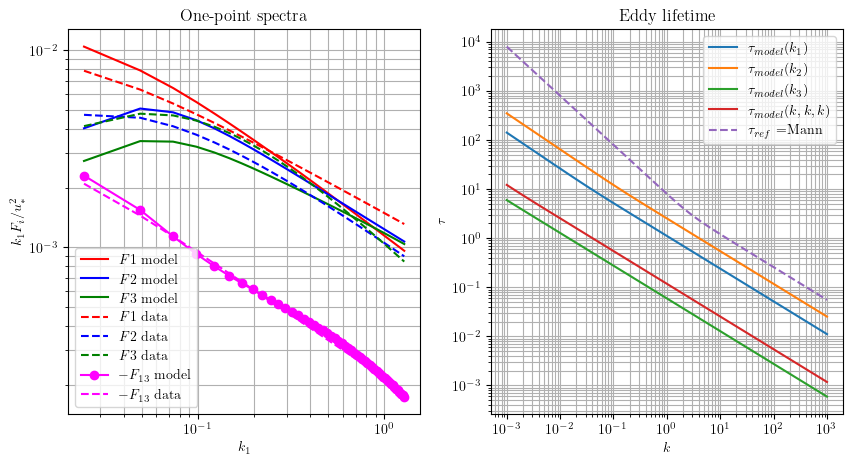

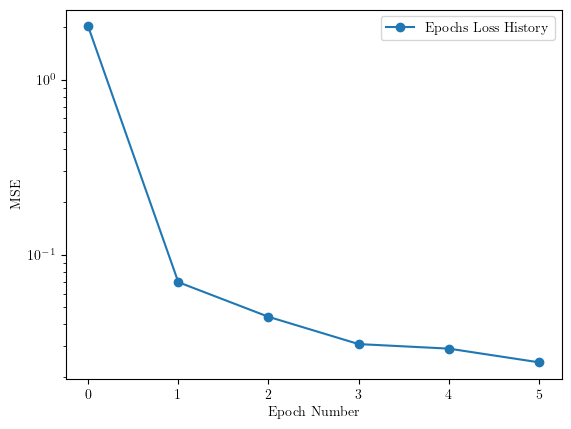

In [3]:
start = time()


config = consts_exp.CONSTANTS_CONFIG
config['data_type'] = 'Auto'
config['nepochs'] = 5

pb = CalibrationProblem(**config)
parameters = pb.parameters
parameters[:3] = [log(consts_exp.L), log(consts_exp.Gamma), log(consts_exp.sigma)] #All of these parameters are positive 
#so we can train the NN for the log of these parameters. 
pb.parameters = parameters[:len(pb.parameters)]

k1_data_pts = config['domain'] #torch.logspace(-1, 2, 20)
spectra_file=config['spectra_file']
print('Reading file' + spectra_file + '\n')
CustomData=torch.tensor(np.genfromtxt(spectra_file,skip_header=1,delimiter=','))
f=CustomData[:,0]
k1_data_pts=2*torch.pi*f/consts_exp.Uref

DataPoints  = [ (k1, 1) for k1 in k1_data_pts ]
Data = OnePointSpectraDataGenerator(DataPoints=DataPoints, k1_data_points=k1_data_pts.cpu().detach().numpy(),**config).Data

data_noise_magnitude = config['noisy_data']
    # data_noise_magnitude = 1.
# if data_noise_magnitude:
    # Data[1][:] *= torch.exp(torch.tensor(np.random.normal(loc=0, scale=data_noise_magnitude, size=Data[1].shape)))

DataValues = Data[1]

IECtau=MannEddyLifetime(k1_data_pts*consts_exp.L)
kF = pb.eval(k1_data_pts)

opt_params = pb.calibrate(Data=Data, **config)#, OptimizerClass=torch.optim.RMSprop)

print(f"Elapsed time : {time() - start}")

plt.figure()

        #plt.plot( pb.loss_history_total, label="Total Loss History")
plt.plot( pb.loss_history_epochs, 'o-', label="Epochs Loss History")
plt.legend() 
plt.xlabel("Epoch Number")
plt.ylabel("MSE")
plt.yscale('log')

plt.show() 

